# Imports set up rendering

In [1]:
#@title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
# %env MUJOCO_GL=egl
os.environ['MUJOCO_GL'] = 'egl'
os.environ['PYOPENGL_PLATFORM'] = 'egl'
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
os.environ["XLA_FLAGS"] = (
    "--xla_gpu_enable_triton_softmax_fusion=true "
    "--xla_gpu_triton_gemm_any=True "
    # "--xla_gpu_enable_async_collectives=true "
    # "--xla_gpu_enable_latency_hiding_scheduler=true "
    # "--xla_gpu_enable_highest_priority_async_stream=true "
)
# os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Use GPU 1
os.environ["XLA_FLAGS"] = (
    "--xla_gpu_enable_triton_softmax_fusion=true " "--xla_gpu_triton_gemm_any=True "
)

Mon Oct 21 08:33:32 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:41:00.0 Off |                  Off |
| 30%   34C    P8             14W /  300W |      11MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%load_ext autoreload
%autoreload 2
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use GPU 1
import functools
import jax
# jax.config.update("jax_enable_x64", True)

n_gpus = jax.device_count(backend="gpu")
print(f"Using {n_gpus} GPUs")
from typing import Dict
from brax import envs
import mujoco
import pickle
import warnings
import mediapy as media
import hydra
import jax.numpy as jp

from omegaconf import DictConfig, OmegaConf
from brax.training.agents.ppo import networks as ppo_networks
from custom_brax import custom_ppo as ppo
from custom_brax import custom_wrappers
from custom_brax import custom_ppo_networks
from orbax import checkpoint as ocp
from flax.training import orbax_utils
from preprocessing.mjx_preprocess import process_clip_to_train
from envs.Fly_Env_Brax import FlyTracking, FlyMultiClipTracking
from utils.utils import *
from utils.fly_logging import log_eval_rollout

warnings.filterwarnings("ignore", category=DeprecationWarning)
# jax.config.update("jax_enable_x64", True)

from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from hydra.core.global_hydra import GlobalHydra


Using 2 GPUs


2024-10-21 08:33:34.118699: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/eabe/miniconda3/envs/stac-mjx-env/lib/python3.11/site-packages/wandb/analytics/sentry.py:90: SentryHubDeprecationWarning: `sentry_sdk.Hub` is deprecated and will be removed in a future major release. Please consult our 1.x to 2.x migration guide for details on how to migrate `Hub` usage to the new API: https://docs.sentry.io/platforms/python/migration/1.x-to-2.x
  self.hub = sentry_sdk.Hub(client)


# Load configs

In [3]:
base_dir ='/data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt'
run_cfg_list = sorted(list(Path(base_dir).rglob('run_config.yaml')))
for n, run_cfg in enumerate(run_cfg_list):
    print(n, run_cfg)


cfg_num = 3
cfg = OmegaConf.load(run_cfg_list[cfg_num])
run_id = int(run_cfg_list[cfg_num].parent.parent.stem.split('=')[1])
print(cfg.dataset.dname)
fig_dir = Path('/data/users/eabe/biomech_model/Flybody/RL_Flybody/debug/figures')

0 /data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21356039/logs/run_config.yaml
1 /data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21377073/logs/run_config.yaml
2 /data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21390629/logs/run_config.yaml
3 /data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21402781/logs/run_config.yaml
4 /data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21426083/logs/run_config.yaml
5 /data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21482334/logs/run_config.yaml
fly_multiclip


In [4]:
dataset = cfg.dataset.dname
with initialize(version_base=None, config_path="configs"):
    cfg_temp=compose(config_name='config.yaml',overrides= [f"dataset={dataset}", f"train=train_{dataset}", "paths=walle", "version=ckpt", f'run_id={run_id}'],return_hydra_config=True,)
    HydraConfig.instance().set_config(cfg_temp)
    
cfg.paths = cfg_temp.paths

In [5]:
for k in cfg.paths.keys():
    if (k != 'user'):
        cfg.paths[k] = Path(cfg.paths[k])
        cfg.paths[k].mkdir(parents=True, exist_ok=True)
env_cfg = cfg.dataset
env_args = cfg.dataset.env_args

cfg.paths.base_dir = cfg.paths.base_dir.parent / 'ckpt'
reference_path = cfg.paths.data_dir/ f"clips/all_clips_batch_interp.p"
# reference_path = cfg.paths.data_dir/ f"clips/{cfg.dataset['clip_idx']}"
reference_path.parent.mkdir(parents=True, exist_ok=True)

with open(reference_path, "rb") as file:
    # Use pickle.load() to load the data from the file
    reference_clip = pickle.load(file)
ref_data = np.concatenate([reference_clip.position,reference_clip.quaternion,reference_clip.joints], axis=-1)

# Load env

In [6]:
from envs.Fly_Env_Brax import FlyTracking, FlyMultiClipTracking, FlyRunSim, _bounded_quat_dist
# dataset = 'multiclip'

# with initialize(version_base=None, config_path="configs"):
#     cfg=compose(config_name='config.yaml',overrides= [f"dataset=fly_{dataset}", f"train=train_fly_{dataset}", "paths=walle"],return_hydra_config=True,)
#     HydraConfig.instance().set_config(cfg)


# env_args = cfg.dataset.env_args
envs.register_environment("fly_freejnt_clip", FlyTracking)
envs.register_environment("fly_freejnt_multiclip", FlyMultiClipTracking)
envs.register_environment("fly_run_policy", FlyRunSim)
# cfg.dataset.env_args.mjcf_path = '/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_viz_only.xml'
# cfg.dataset.env_args.mjcf_path = '/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_force_fast.xml'
print(cfg.train.env_name)
cfg.dataset.env_args.iterations = 12
cfg.dataset.env_args.ls_iterations = 12
env = envs.get_environment(
    cfg.train.env_name,
    reference_clip=reference_clip,
    **cfg.dataset.env_args,
)

fly_freejnt_multiclip
Loaded Model: /home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_force_fast.xml
self._steps_for_cur_frame: 1.0


In [7]:
rollout_env = custom_wrappers.RenderRolloutWrapperTracking(env)
    
# rollout_env = custom_wrappers.RenderRolloutWrapperTracking(env)
# define the jit reset/step functions
jit_reset = jax.jit(rollout_env.reset)
jit_step = jax.jit(rollout_env.step)
state = jit_reset(jax.random.PRNGKey(0))


# Test inference

In [8]:
from orbax import checkpoint as ocp
from flax.training import orbax_utils
import optax

In [9]:
model_path = Path(cfg.paths.ckpt_dir/f"{run_id}")
##### Get all the checkpoint files #####
ckpt_files = sorted([Path(f.path) for f in os.scandir(model_path) if f.is_dir()])
max_ckpt = ckpt_files[-1].as_posix()
env_args = cfg.dataset.env_args
print(max_ckpt)

/data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21402781/ckpt/21402781/058


In [10]:
def policy_params_fn(num_steps, make_policy, params, policy_params_fn_key, model_path=model_path):
  # save checkpoints
  orbax_checkpointer = ocp.PyTreeCheckpointer()
  save_args = orbax_utils.save_args_from_target(params)
  path = Path('/data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21356039/ckpt/Test_path') / f'{num_steps}'
  orbax_checkpointer.save(path, params, force=True, save_args=save_args)
  
  
episode_length = (env_args.clip_length - 50 - env_cfg.ref_traj_length) * env._steps_for_cur_frame
print(f"episode_length {episode_length}")

train_fn = functools.partial(
            ppo.train,
            num_envs=cfg.train["num_envs"],
            num_timesteps=0,
            num_evals=1,
            num_resets_per_eval=cfg.train['num_resets_per_eval'],
            reward_scaling=cfg.train['reward_scaling'],
            episode_length=episode_length,
            normalize_observations=True,
            action_repeat=cfg.train['action_repeat'],
            clipping_epsilon=cfg.train["clipping_epsilon"],
            unroll_length=cfg.train['unroll_length'],
            num_minibatches=cfg.train["num_minibatches"],
            num_updates_per_batch=cfg.train["num_updates_per_batch"],
            discounting=cfg.train['discounting'],
            learning_rate=cfg.train["learning_rate"],
            kl_weight=cfg.train["kl_weight"],
            entropy_cost=cfg.train['entropy_cost'],
            batch_size=cfg.train["batch_size"],
            seed=cfg.train['seed'],
            network_factory=functools.partial(
                custom_ppo_networks.make_intention_ppo_networks,
                encoder_hidden_layer_sizes=cfg.train['encoder_hidden_layer_sizes'],
                decoder_hidden_layer_sizes=cfg.train['decoder_hidden_layer_sizes'],
                value_hidden_layer_sizes=cfg.train['value_hidden_layer_sizes'],
            ),
            restore_checkpoint_path=max_ckpt,
        )

make_inference_fn, params, _= train_fn(environment=env,)
params2 = (params[0],params[1].policy)
policy_params = (params[0],params[1].policy)
# Env_steps = params[2]
jit_inference_fn = jax.jit(make_inference_fn(policy_params, deterministic=True))

episode_length 946.0


In [11]:
env._n_clips, env._clip_length

(17, 1001)

In [12]:
rollout_data = {'clip{:02d}'.format(n): {} for n in range(env._n_clips)}
# for n in range(env._n_clips):
n = 0
# reset_rng, act_rng = jax.random.split(policy_params_fn_key)
rng = jax.random.PRNGKey(0)
reset_rng, act_rng = jax.random.split(rng)
state = jit_reset(reset_rng)
state.info['clip_idx'] = n
print(state.info['clip_idx'])

rollout = [state]
# rollout_len = env_args["clip_length"]*int(rollout_env._steps_for_cur_frame)
rollout_len = env._clip_length
ctrl_all = []
for i in range(rollout_len):
    _, act_rng = jax.random.split(act_rng)
    obs = state.obs
    ctrl, extras = jit_inference_fn(obs, act_rng)
    state = jit_step(state, ctrl)
    ctrl_all.append(ctrl.copy())
    rollout.append(state)
rollout2 = [state.pipeline_state for state in rollout]
rollout_data['clip{:02d}'.format(n)]['qposes'] = jp.stack([state.qpos for state in rollout2])
rollout_data['clip{:02d}'.format(n)]['qvels'] = jp.stack([state.qvel for state in rollout2])
rollout_data['clip{:02d}'.format(n)]['ctrl'] = jp.stack(ctrl_all)
# rollout_data['clip{:02d}'.format(n)]['sensordata'] = jp.stack([state.sensordata for state in rollout2])


0


In [13]:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

pixels = rollout_env.render(rollout2[500:], camera='track1', width=480, height=480, scene_option=scene_option)
media.show_video(pixels,fps=50)

In [ ]:
ctrl_all = jp.array(ctrl_all)
model_path = "/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_fastviz.xml"
spec = mujoco.MjSpec()
spec = spec.from_file(model_path)
thorax = spec.find_body("thorax")
first_joint = thorax.first_joint()
# first_joint.delete()
root = spec.compile()
root.opt.solver = {
    "cg": mujoco.mjtSolver.mjSOL_CG,
    "newton": mujoco.mjtSolver.mjSOL_NEWTON,
}[cfg.dataset.env_args.solver.lower()]
root.opt.iterations = env_args.iterations
root.opt.ls_iterations = env_args.ls_iterations
root.opt.timestep = env_args.physics_timestep
root.opt.jacobian = 0
data = mujoco.MjData(root)
data.qpos = qposes_rollout[0]
mujoco.mj_forward(root, data)
n_frames = ctrl_all.shape[0]
height = 512
width = 512
frames = []
fps = 1/env.dt
times = []
sensordata = []
scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]

scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

qpos_all,rollout,ncon_all = [],[],[]
with mujoco.Renderer(root, height, width) as renderer:
    for i in range(n_frames):
        data.ctrl = ctrl_all[i].copy()
        # data.qpos = qposes_rollout[i].copy()
        while data.time < i/fps:
            mujoco.mj_step(root, data)
            sensordata.append(data.sensordata.copy())
        times.append(data.time)
        renderer.update_scene(data,camera='track1',scene_option=scene_option)
        frame = renderer.render()
        frames.append(frame)
        qpos_all.append(data.qpos.copy())
        ncon_all.append(data.ncon)
        rollout.append(data)

media.show_video(frames, fps=50)


In [15]:
end_eff = [
'claw_T1_left',
'claw_T1_right',
'claw_T2_left',
'claw_T2_right',
'claw_T3_left',
'claw_T3_right',
]

In [16]:
# 1 (mg cm) / (s^2) = 1.0 × 10-8 newtons

In [ ]:
N = 100
sdata = 1e-8*(np.stack(sensordata).reshape(-1,6,3)) # Time x end_eff x xyz, x=forward
sdata = np.apply_along_axis(lambda m: np.convolve(m, np.ones(N)/N, mode='full'), axis=0, arr=sdata)

fig, axs = plt.subplots(3, 2, figsize=(10, 10), sharey=True)
axs = axs.flatten()
for n in range(len(end_eff)):
    ax = axs[n]
    ax.plot(sdata[:,n,0])
    ax.plot(sdata[:,n,1])
    ax.plot(sdata[:,n,2])
# plt.plot(sdata[:,:,2])

# Test reward functions

In [ ]:
env._reference_clip.quaternion[0], reference_clip.quaternion[0],state.pipeline_state.qpos[3:7]
env._reference_clip.position[0], reference_clip.position[0],state.pipeline_state.qpos[:3]
env._reference_clip.joints[0], reference_clip.joints[0],state.pipeline_state.qpos[7:]


In [27]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
for i in range(100):
    # ctrl = ctrl_mpc[i]
    # ctrl = 5*jax.random.normal(rng, shape=(env.sys.nu,), dtype=jp.float32)
    ctrl = jp.zeros((env.sys.nu,))
    # dpos =jp.array([jp.sum(reference_clip.lin_vel_y[:i]*env.dt),0,0])
    # qpos_t = jp.concatenate((reference_clip.position[i]+dpos,reference_clip.quaternion[i], reference_clip.joints[i]))
    # qpos_t = jp.concatenate((reference_clip.position[i],reference_clip.quaternion[i], reference_clip.joints[i]))
    # qvel_t = jp.concatenate((reference_clip.velocity[i],reference_clip.angular_velocity[i], reference_clip.joints_velocity[i]))
    # pipeline = state.pipeline_state.replace(qpos=qpos_t, qvel=qvel_t)
    # pipeline = state.pipeline_state.replace(qpos=reference_clip.joints[i], qvel=reference_clip.joints_velocity[i])
    # state=state.replace(pipeline_state=pipeline)
    state = jit_step(state, ctrl)
    rollout.append(state.pipeline_state)

scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]

scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

pixels = env.render(rollout, width=256, height=256, camera=1,scene_option=scene_option) 


In [ ]:
# print(env.time)
scene_option = mujoco.MjvOption()
scene_option.geomgroup[:] = [1, 1, 0, 0, 0, 0]
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]

scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
# pixels = env.render(rollout, width=1000, height=1000, camera=1,scene_option=scene_option) 
media.show_video(pixels, fps=50)

In [28]:
_pos_reward_weight = 1
_joint_reward_weight = 1
_angvel_reward_weight = 1
_bodypos_reward_weight = 1
_endeff_reward_weight = 1
_quat_reward_weight = 1
_pos_scaling = 400.0
_joint_scaling = 0.25
_angvel_scaling = 0.5
_bodypos_scaling = 4.0
_endeff_scaling = 0.05
_quat_scaling = 500.0
clip_idx=0
rewards = {'pos':[],'joint':[], 'angvel':[], 'bodypos':[], 'endeff':[],'pos_reward':[], 'joint_reward':[], 'angvel_reward':[], 'bodypos_reward':[], 'endeff_reward':[], 'quat_distance':[], 'quat_reward':[]}
for cur_frame in range (1000): 
    data= rollout[cur_frame].pipeline_state
    
    quat_track = reference_clip.position[clip_idx,cur_frame]
    pos_distance = jp.sum((data.qpos[:3] - quat_track)**2)
    pos_reward = _pos_reward_weight * jp.exp(-_pos_scaling * pos_distance)
    
    quat_track = reference_clip.quaternion[clip_idx,cur_frame]
    quat_distance = jp.sum(_bounded_quat_dist(data.qpos[3:7], quat_track) ** 2)
    quat_reward = _quat_reward_weight * jp.exp(-_quat_scaling * quat_distance)
    
    joint_track = reference_clip.joints[clip_idx,cur_frame]
    joint_distance = jp.sum((data.qpos[7:] - joint_track) ** 2)
    joint_reward = _joint_reward_weight * jp.exp(-_joint_scaling * joint_distance)
    
    angvel_track = reference_clip.angular_velocity[clip_idx,cur_frame]
    angvel_distance = jp.sum((data.qvel[3:6] - angvel_track) ** 2)
    angvel_reward = _angvel_reward_weight * jp.exp(-_angvel_scaling * angvel_distance)
    
    bodypos_track = reference_clip.body_positions[clip_idx,cur_frame]
    bodypos_distance = jp.sum((data.xpos[env._body_idxs]- bodypos_track[env._body_idxs]).flatten()** 2)
    bodypos_reward = _bodypos_reward_weight * jp.exp(-_bodypos_scaling* bodypos_distance)
    
    endeff_track = reference_clip.body_positions[clip_idx,cur_frame]
    endeff_distance = jp.sum((data.xpos[env._endeff_idxs]- endeff_track[env._endeff_idxs]).flatten()** 2)
    endeff_reward = _endeff_reward_weight * jp.exp(-_endeff_scaling* endeff_distance)

        
    rewards['pos'].append(pos_distance)
    rewards['joint'].append(joint_distance)
    rewards['angvel'].append(angvel_distance)
    rewards['bodypos'].append(bodypos_distance)
    rewards['endeff'].append(endeff_distance)
    rewards['quat_distance'].append(quat_distance)
    
    rewards['pos_reward'].append(pos_reward)
    rewards['joint_reward'].append(joint_reward)
    rewards['angvel_reward'].append(angvel_reward)
    rewards['bodypos_reward'].append(bodypos_reward)
    rewards['endeff_reward'].append(endeff_reward)
    rewards['quat_reward'].append(quat_reward)
    


(-0.1, 1.1)

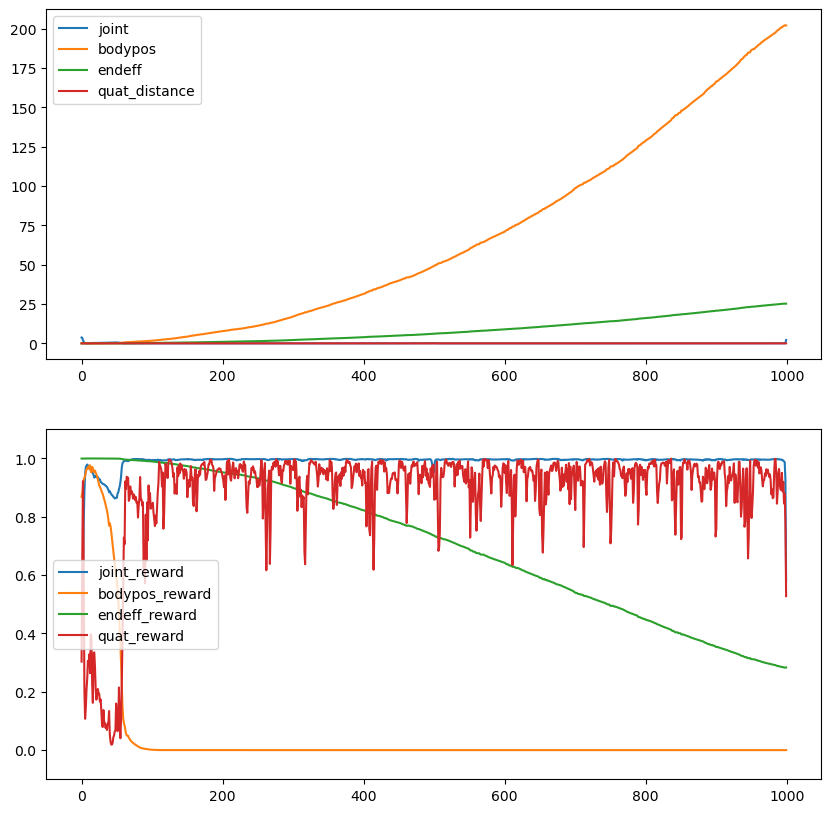

In [30]:

fig, axs = plt.subplots(2,1, figsize=(10,10))
ax = axs[0]
# ax.plot(rewards['pos'], label='pos')
ax.plot(rewards['joint'], label='joint')
# ax.plot(rewards['angvel'], label='angvel')
ax.plot(rewards['bodypos'], label='bodypos')
ax.plot(rewards['endeff'], label='endeff')
ax.plot(rewards['quat_distance'], label='quat_distance')
ax.legend()

ax = axs[1]
# ax.plot(rewards['pos_reward'], label='pos_reward')
ax.plot(rewards['joint_reward'], label='joint_reward')
# ax.plot(rewards['angvel_reward'], label='angvel_reward')
ax.plot(rewards['bodypos_reward'], label='bodypos_reward')
ax.plot(rewards['endeff_reward'], label='endeff_reward')
ax.plot(rewards['quat_reward'], label='quat_reward')
ax.legend()
ax.set_ylim(-.1,1.1)



In [23]:
render_path = Path(cfg.dataset.rendering_mjcf).parent / 'fruitfly_force_pair.xml'

In [24]:
qposes_rollout = jp.array([data.qpos for data in rollout])
def f(x):
    if (not isinstance(x,str)):
        if (len(x.shape) != 1):
            return jax.lax.dynamic_slice_in_dim(
                x,
                0,
                qposes_rollout.shape[0],
            )
    return jp.array([])

ref_traj = jax.tree_util.tree_map(f, env._reference_clip)

repeats_per_frame = 1 #env._steps_for_cur_frame #int(1/(env._mocap_hz*env.sys.mj_model.opt.timestep))
spec = mujoco.MjSpec()
spec.from_file(render_path.as_posix())
thorax0 = spec.find_body("thorax-0")
first_joint0 = thorax0.first_joint()
if (env._free_jnt == False) & ('free' in first_joint0.name):
    qposes_ref = np.repeat(
        ref_traj.joints,
        repeats_per_frame,
        axis=0,
    )
    # qposes_ref = ref_traj.joints.copy()

    first_joint0.delete()
    thorax1 = spec.find_body("thorax-1")
    first_joint1 = thorax1.first_joint()
    first_joint1.delete()
elif env._free_jnt == True: 
    # qposes_ref = np.hstack([ref_traj.position, ref_traj.quaternion, ref_traj.joints])
    qposes_ref = np.repeat(
        np.hstack([ref_traj.position, ref_traj.quaternion, ref_traj.joints]),
        repeats_per_frame,
        axis=0,
    )
    
mj_model = spec.compile()

mj_model.opt.solver = {
    "cg": mujoco.mjtSolver.mjSOL_CG,
    "newton": mujoco.mjtSolver.mjSOL_NEWTON,
}["cg"]
mj_model.opt.iterations = cfg.dataset.env_args.iterations
mj_model.opt.ls_iterations = cfg.dataset.env_args.ls_iterations
mj_model.opt.timestep = env.sys.mj_model.opt.timestep

mj_data = mujoco.MjData(mj_model)

site_names = [
    mj_model.site(i).name
    for i in range(mj_model.nsite)
    if "-0" in mj_model.site(i).name
]
site_id = [
    mj_model.site(i).id
    for i in range(mj_model.nsite)
    if "-0" in mj_model.site(i).name
]
for id in site_id:
    mj_model.site(id).rgba = [1, 0, 0, 1]

scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

# save rendering and log to wandb
os.environ["MUJOCO_GL"] = "osmesa"
mujoco.mj_kinematics(mj_model, mj_data)
# renderer = mujoco.Renderer(mj_model, height=512, width=512)

frames = []
# render while stepping using mujoco
# video_path = f"{model_path}/{num_steps}.mp4"
# with imageio.get_writer(video_path, fps=50) as video:
with mujoco.Renderer(mj_model, height=512, width=512) as renderer:
    for qpos1, qpos2 in zip(qposes_rollout, qposes_ref):
        mj_data.qpos = np.append(qpos1, qpos2)
        mujoco.mj_forward(mj_model, mj_data)
        renderer.update_scene(mj_data, camera=1, scene_option=scene_option)
        pixels = renderer.render()
        # video.append_data(pixels)
        frames.append(pixels)

In [ ]:
media.show_image(frames[0])

In [ ]:
media.show_video(frames, fps=50)


In [40]:
mpc1_data = ioh5.load('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/fruitfly_qpos2_002ms.h5')
ctrl_mpc = jp.array(mpc1_data['ctrl'].T)
qpos_mpc = jp.array(mpc1_data['qpos'].T)

In [ ]:
model_path = ("/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_force_fastball.xml")
spec = mujoco.MjSpec()
spec.from_file(model_path)
thorax = spec.find_body("thorax")
first_joint = thorax.first_joint()
first_joint.delete()
mj_model = spec.compile()

mj_model.opt.timestep = 0.0002
data = mujoco.MjData(mj_model)
mujoco.mj_forward(mj_model, data)
n_frames = 100
height = 240
width = 320
frames = []
fps = 1/.002
times = []
# sensordata = []
scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]

scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
qpos_rollout = []
qvel_rollout = []
xpos_rollout = []
xquat_rollout = []
with mujoco.Renderer(mj_model, height, width) as renderer:
    for i in range(n_frames):
        # data.ctrl = ctrl_mpc[i]
        # data.qpos = np.concatenate([np.zeros(4),qpos_mpc[i]])
        # data.qpos = reference_clip.joints[i]
        data.qpos = np.concatenate([np.zeros(4),reference_clip.joints[i]])
        # mujoco.mj_forward(mj_model, data)
        # while data.time < i/fps:
        mujoco.mj_step(mj_model,data)
        qpos_rollout.append(data.qpos.copy())
        qvel_rollout.append(data.qvel.copy())
        xpos_rollout.append(data.xpos.copy())
        xquat_rollout.append(data.xquat.copy())
        # times.append(data.time)
        #     sensordata.append(data.sensor('force_tarsus_T1_left').data.copy())
        renderer.update_scene(data,camera=1,scene_option=scene_option)
        frame = renderer.render()
        frames.append(frame)
        
    
# # grab a trajectory
# for i in range(times.shape[0]):
#     data.ctrl = ctrl[i]
#     state = mujoco.mj_step(mj_model,data)
#     rollout.append(state)

media.show_video(frames, fps=50)


In [12]:
qpos_rollout = jp.array(qpos_rollout)
qvel_rollout = jp.array(qvel_rollout)
xpos_rollout = jp.array(xpos_rollout)
xquat_rollout = jp.array(xquat_rollout)

In [ ]:
env.dt

In [51]:
model_path = ("/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_force_fast.xml")
spec = mujoco.MjSpec()
spec.from_file(model_path)
thorax = spec.find_body("thorax")
first_joint = thorax.first_joint()
# first_joint.delete()
mj_model = spec.compile()

mj_model.opt.timestep = 0.0002
data = mujoco.MjData(mj_model)
mujoco.mj_forward(mj_model, data)
n_frames = 100
height = 240
width = 320
frames = []
fps = 1/.002
times = []
# sensordata = []
scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]

scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
qpos_rollout = []
qvel_rollout = []
xpos_rollout = []
xquat_rollout = []

with mujoco.Renderer(mj_model, height, width) as renderer:
    for i in range(n_frames):

        data.qpos = np.concatenate([reference_clip.position[i],reference_clip.quaternion[i],reference_clip.joints[i]])
        mujoco.mj_step(mj_model,data)
        qpos_rollout.append(data.qpos.copy())
        qvel_rollout.append(data.qvel.copy())
        xpos_rollout.append(data.xpos.copy())
        xquat_rollout.append(data.xquat.copy())
        # times.append(data.time)
        #     sensordata.append(data.sensor('force_tarsus_T1_left').data.copy())
        renderer.update_scene(data,camera=1,scene_option=scene_option)
        frame = renderer.render()
        frames.append(frame)

In [ ]:
np.array(xpos_rollout)[:, :,2].min()

In [ ]:
media.show_image(frames[-1])

## Render ball mujoco

In [ ]:
mpc1_data = ioh5.load('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/fruitfly_qpos2_002ms.h5')
ctrl_mpc = jp.array(mpc1_data['ctrl'].T)
model_path = ("/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_force_fastball.xml")
spec = mujoco.MjSpec()
spec.from_file(model_path)
thorax = spec.find_body("thorax")
first_joint = thorax.first_joint()
first_joint.delete()
root = spec.compile()
root.opt.timestep = 0.0002
data = mujoco.MjData(root)
n_frames = 200
height = 240
width = 320
frames = []
fps = 1/.002
times = []
sensordata = []
scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]

scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

rollout = []
with mujoco.Renderer(root, height, width) as renderer:
    for i in range(n_frames):
        data.ctrl = ctrl_mpc[i]
        while data.time < i/fps:
            mujoco.mj_step(root, data)
        times.append(data.time)
        sensordata.append(data.sensor('force_tarsus_T1_left').data.copy())
        renderer.update_scene(data,camera=1,scene_option=scene_option)
        frame = renderer.render()
        frames.append(frame)
        rollout.append(data)
            
# # grab a trajectory
# for i in range(times.shape[0]):
#     data.ctrl = ctrl[i]
#     state = mujoco.mj_step(root,data)
#     rollout.append(state)

media.show_video(frames, fps=50)
# pixels = env.render(rollout, width=1000, height=1000, camera=3,scene_option=scene_option) 

In [ ]:
plt.plot(sensordata[:100])
plt.legend(['x','y','z'])

In [ ]:
env._ref_traj.body_quaternions.shape, data.xquat.shape

In [ ]:
rng, cmd_rng = jax.random.split(state.info["rng"], 2)

state.info["steps_taken_cur_frame"] += 1
state.info["cur_frame"] += jp.where(
    state.info["steps_taken_cur_frame"] == env._steps_for_cur_frame, 1, 0
)
state.info["steps_taken_cur_frame"] *= jp.where(
    state.info["steps_taken_cur_frame"] == env._steps_for_cur_frame, 0, 1
)
# physics step
data0 = state.pipeline_state
pipeline_state = env.pipeline_step(data0, action)
# motor_targets = env._default_pose + action * env._action_scale
# motor_targets = jp.clip(motor_targets, env.lowers, env.uppers)
# pipeline_state = env.pipeline_step(state.pipeline_state, motor_targets)
x, xd = pipeline_state.x, pipeline_state.xd


In [ ]:

min_z, max_z = env._healthy_z_range
is_healthy = jp.where(pipeline_state.xpos[env._thorax_idx][2] < min_z, 0.0, 1.0)
is_healthy = jp.where(pipeline_state.xpos[env._thorax_idx][2] > max_z, 0.0, is_healthy)
if env._terminate_when_unhealthy:
    healthy_reward = env._healthy_reward
else:
    healthy_reward = env._healthy_reward * is_healthy


In [ ]:

# obs = env._get_obs(pipeline_state, state.info, state.obs)
joint_angles = pipeline_state.q[7:]
joint_vel = pipeline_state.qd  ##### need to restrict to only legs

# foot contact data based on z-position
foot_pos = pipeline_state.site_xpos[
    env._endeff_idxs
]  # pytype: disable=attribute-error
foot_contact_z = foot_pos[:, 2] - env._foot_radius
contact = foot_contact_z < -.141  # a mm or less off the floor
# contact_filt_mm = contact | state.info["last_contact"]
# contact_filt_cm = (foot_contact_z < 3e-2) | state.info["last_contact"]


In [ ]:
foot_contact_z, contact

In [ ]:

# done if joint limits are reached or robot is falling
up = jp.array([0.0, 0.0, 1.0])
done = jp.dot(brax_math.rotate(up, x.rot[env._thorax_idx]), up) < 0
done |= jp.any(joint_angles < env.lowers)
done |= jp.any(joint_angles > env.uppers)
done |= pipeline_state.x.pos[env._thorax_idx, 2] < min_z
done |= pipeline_state.x.pos[env._thorax_idx, 2] > max_z

done

# Test retrain

In [ ]:
dataset = 'freejnt_force'

from envs.Fly_Env_Brax import FlyTracking, FlyMultiClipTracking, _bounded_quat_dist
with initialize(version_base=None, config_path="configs"):
    cfg=compose(config_name='config.yaml',overrides= [f"dataset=fly_{dataset}", f"train=train_fly_{dataset}", "paths=walle"],return_hydra_config=True,)
    HydraConfig.instance().set_config(cfg)
    

env_args = cfg.dataset.env_args
print(cfg.train.env_name)
envs.register_environment("fly_freejnt_clip", FlyTracking)
envs.register_environment("fly_freejnt_multiclip", FlyMultiClipTracking)
cfg_load = OmegaConf.load('/data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21377073//logs/run_config.yaml')
cfg_load.paths = cfg.paths
env = envs.get_environment(
    cfg.train.env_name,
    reference_clip=reference_clip,
    **cfg.dataset.env_args,
)

In [8]:
from orbax import checkpoint as ocp
from flax.training import orbax_utils
import optax

In [ ]:
model_path = Path('/data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21377073/ckpt/21377073')
##### Get all the checkpoint files #####
ckpt_files = sorted([Path(f.path) for f in os.scandir(model_path) if f.is_dir()])
max_ckpt = ckpt_files[-1].as_posix()
env_args = cfg.dataset.env_args
print(max_ckpt)

In [ ]:
def policy_params_fn(num_steps, make_policy, params, policy_params_fn_key, model_path=model_path):
  # save checkpoints
  orbax_checkpointer = ocp.PyTreeCheckpointer()
  save_args = orbax_utils.save_args_from_target(params)
  path = Path('/data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21356039/ckpt/Test_path') / f'{num_steps}'
  orbax_checkpointer.save(path, params, force=True, save_args=save_args)
  
  
episode_length = (env_args.clip_length - 50 - env_cfg.ref_traj_length) * env._steps_for_cur_frame
print(f"episode_length {episode_length}")

train_fn = functools.partial(
            ppo.train,
            num_envs=cfg.train["num_envs"],
            num_timesteps=0,
            num_evals=1,
            num_resets_per_eval=cfg.train['num_resets_per_eval'],
            reward_scaling=cfg.train['reward_scaling'],
            episode_length=episode_length,
            normalize_observations=True,
            action_repeat=cfg.train['action_repeat'],
            clipping_epsilon=cfg.train["clipping_epsilon"],
            unroll_length=cfg.train['unroll_length'],
            num_minibatches=cfg.train["num_minibatches"],
            num_updates_per_batch=cfg.train["num_updates_per_batch"],
            discounting=cfg.train['discounting'],
            learning_rate=cfg.train["learning_rate"],
            kl_weight=cfg.train["kl_weight"],
            entropy_cost=cfg.train['entropy_cost'],
            batch_size=cfg.train["batch_size"],
            seed=cfg.train['seed'],
            network_factory=functools.partial(
                custom_ppo_networks.make_intention_ppo_networks,
                encoder_hidden_layer_sizes=cfg.train['encoder_hidden_layer_sizes'],
                decoder_hidden_layer_sizes=cfg.train['decoder_hidden_layer_sizes'],
                value_hidden_layer_sizes=cfg.train['value_hidden_layer_sizes'],
            ),
            restore_checkpoint_path=max_ckpt,
        )

make_inference_fn, params, _= train_fn(environment=env,)
params2 = (params[0],params[1].policy)
# make_inference_fn, params, _= ppo.train(environment=env, num_timesteps=0, episode_length=1000, policy_params_fn=policy_params_fn, restore_checkpoint_path=ckpt_path / '3072000')

In [27]:
def walk_dict(d, depth=0):
    ''' Recurssively Walks through a dictionary and prints the keys and values'''
    for k,v in sorted(d.items(),key=lambda x: x[0]):
        if isinstance(v, dict):
            if k=='decoder':
                return {'set_zero': {'decoder': jax.tree_map(lambda x: fn('set_zero',x), v)}}
            else:
                return {'adam': jax.tree_map(lambda x: fn('adam',x), v)}
        else:
            return fn('adam',x)

In [ ]:
walk_dict(params[1].__dict__)

In [13]:
from brax.training.acme import running_statistics
from custom_brax.custom_losses import PPONetworkParams


In [ ]:

from jax import tree_util

def apply_conditionally(tree, condition_tree, func_true, func_false):
    """Applies func_true or func_false to each leaf of the tree based on the corresponding condition."""

    def _apply_func(condition, value):
        return jax.lax.cond(condition, lambda x: func_true(x), lambda x: func_false(x), value)

    return jax.tree_map(_apply_func, condition_tree, tree)


result = apply_conditionally(tree, condition_tree, lambda x: fn('adam',x), lambda x: fn('set_zero',x))

print(result)

In [29]:
def map_nested_fn(fn):
    def walk_dict(d, depth=0):
        ''' Recurssively Walks through a dictionary and prints the keys and values'''
        for k,v in sorted(d.items(),key=lambda x: x[0]):
            if isinstance(v, dict):
                if k=='decoder':
                    return {'set_zero': {'decoder': jax.tree_map(lambda x: fn('set_zero',x), v)}}
                else:
                    return {'adam': jax.tree_map(lambda x: fn('adam',x), v)}
    return fn('adam',x)

In [ ]:
params.policy.keys

In [30]:
# def map_nested_fn(fn):
#     '''Recursively apply `fn` to key-value pairs of a nested dict.'''

#     def map_fn(nested_val):
#         if isinstance(nested_val, tuple):
#             for n,val in enumerate(nested_val):
#                 return map_fn(val)
#         if isinstance(nested_val, running_statistics.RunningStatisticsState):
#             return fn('adam', nested_val)
#         if isinstance(v, PPONetworkParams):
#                 return{'policy': fn(k, v.policy),
#                         'value': fn(k, v.value)}
#         if isinstance(v, dict):
#             for k, v in nested_val.items():
#                 if k == 'decoder':
#                     return fn('set_zero', v)
#                 else:
#                     return fn('adam', v)    
#     return map_fn


def map_nested_fn(fn):
    '''Recursively apply `fn` to Parameters to freeze.'''

    def map_fn(nested_val,decoder=False):
        if isinstance(nested_val, dict):
            for k, v in nested_val.items():
                if k == 'decoder':
                    return map_fn(v,decoder=True)
                elif decoder:
                    return fn('decoder', v)
                else:
                    print('adam',v)
                    return fn('adam', v)
        if isinstance(nested_val, PPONetworkParams):
            for n in [nested_val.value['params'],nested_val.policy['params']]:
                return map_fn(n)
    return map_fn

In [ ]:

def construct_key_value_pairs(tree):
    def map_func(leaf):
        if isinstance(leaf,dict):
            for k,v in leaf.items():
                map_func(k,v)
                if k == 'decoder':
                    return {'decoder':k}
                else:
                    return {'adam':k}
            return {'key': 'positive', 'value': leaf}
        else:
            return {'key': 'other', 'value': leaf}
    return tree_map(map_func, tree)

In [136]:
params_dict={}
params_dict['encoder'] = params[1].policy['params']['encoder']
params_dict['decoder'] =  params[1].policy['params']['decoder']
params_dict['value'] = params[1].value

In [ ]:

def map_nested_fn(fn):
    '''Recursively apply `fn` to key-value pairs of a nested dict.'''
    def map_fn(nested_dict):
        return {'set_zero': (map_fn(v) if (isinstance(v, dict) & k=='decoder') else fn('adam', v)) for k, v in nested_dict.items()}
    
    
# def map_nested_fn(fn):
#     '''Recursively apply `fn` to Parameters to freeze.'''
#     def map_fn(nested_val):
#         if isinstance(nested_val, dict):
#             return {k: (map_fn(v) if (if isinstance(nested_val, dict)) fn('set_zero',v) elif k=='decoder' else fn('adam', v)) for k, v in nested_val.items()}
#     return map_fn


label_fn = map_nested_fn(lambda k, _: k)


optimizer = optax.multi_transform(
                    {
                     'adam': optax.adam(cfg.train["learning_rate"]), 
                     'set_zero': optax.set_to_zero()
                     },
                    {'decoder': 'set_zero', 'encoder':'adam'}
                    )

opt_state = optimizer.init(params[1].__dict__)

opt_state # Should have a mask in adam and decoder should be masked with zeros but everything stops after the first return or errors cause of list. 

In [124]:
optimizer = optax.multi_transform(
                    {
                     'adam': optax.adam(cfg.train["learning_rate"]), 
                     'decoder': optax.set_to_zero()
                     },
                    label_fn
                    )

opt_state = optimizer.init(params)

In [ ]:
opt_state

In [212]:
optimizer = optax.adam(learning_rate=cfg.train['learning_rate'])
opt_state = optimizer.init(params[:2])

In [ ]:
opt_state

In [42]:
def render_pair_video(qposes_rollout,cfg,reference_clip,env,model_path,num_steps): 
    def f(x):
        if (not isinstance(x,str)):
            if (len(x.shape) != 1):
                return jax.lax.dynamic_slice_in_dim(
                    x,
                    0,
                    cfg.dataset.env_args["clip_length"],
                )
        return jp.array([])
    
    ref_traj = jax.tree_util.tree_map(f, env._reference_clip)
    
    repeats_per_frame = 1 # env._steps_for_cur_frame #int(1/(env._mocap_hz*env.sys.mj_model.opt.timestep))
    spec = mujoco.MjSpec()
    spec.from_file(cfg.dataset.rendering_mjcf)
    thorax0 = spec.find_body("thorax-0")
    first_joint0 = thorax0.first_joint()
    if (env._free_jnt == False) & ('free' in first_joint0.name):
        qposes_ref = np.repeat(
            ref_traj.joints,
            repeats_per_frame,
            axis=0,
        )
        # qposes_ref = ref_traj.joints.copy()

        first_joint0.delete()
        thorax1 = spec.find_body("thorax-1")
        first_joint1 = thorax1.first_joint()
        first_joint1.delete()
    elif env._free_jnt == True: 
        # qposes_ref = np.hstack([ref_traj.position, ref_traj.quaternion, ref_traj.joints])
        qposes_ref = np.repeat(
            np.hstack([ref_traj.position, ref_traj.quaternion, ref_traj.joints]),
            repeats_per_frame,
            axis=0,
        )
        
    mj_model = spec.compile()

    mj_model.opt.solver = {
        "cg": mujoco.mjtSolver.mjSOL_CG,
        "newton": mujoco.mjtSolver.mjSOL_NEWTON,
    }["cg"]
    mj_model.opt.iterations = cfg.dataset.env_args.iterations
    mj_model.opt.ls_iterations = cfg.dataset.env_args.ls_iterations
    mj_model.opt.timestep = env.sys.mj_model.opt.timestep
    
    mj_data = mujoco.MjData(mj_model)
    
    site_names = [
        mj_model.site(i).name
        for i in range(mj_model.nsite)
        if "-0" in mj_model.site(i).name
    ]
    site_id = [
        mj_model.site(i).id
        for i in range(mj_model.nsite)
        if "-0" in mj_model.site(i).name
    ]
    for id in site_id:
        mj_model.site(id).rgba = [1, 0, 0, 1]

    scene_option = mujoco.MjvOption()
    scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

    # save rendering and log to wandb
    os.environ["MUJOCO_GL"] = "osmesa"
    mujoco.mj_kinematics(mj_model, mj_data)
    # renderer = mujoco.Renderer(mj_model, height=512, width=512)

    frames = []
    # render while stepping using mujoco
    video_path = f"{model_path}/{num_steps}.mp4"
    with imageio.get_writer(video_path, fps=50) as video:
        with mujoco.Renderer(mj_model, height=512, width=512) as renderer:
            for qpos1, qpos2 in zip(qposes_rollout, qposes_ref):
                mj_data.qpos = np.append(qpos1, qpos2)
                mujoco.mj_forward(mj_model, mj_data)
                renderer.update_scene(mj_data, camera=1, scene_option=scene_option)
                pixels = renderer.render()
                video.append_data(pixels)
                frames.append(pixels)

def policy_params_fn(num_steps, make_policy, params, model_path=model_path):
    print('num_steps:', num_steps)
    num_steps=int(num_steps)
    ckptr = ocp.Checkpointer(ocp.PyTreeCheckpointHandler())
    save_args = orbax_utils.save_args_from_target(params)
    path = model_path / f'retrain_{num_steps}'
    os.makedirs(path, exist_ok=True)
    ckptr.save(path, params, force=True, save_args=save_args)
    policy_params_key = jax.random.key(0)
    policy_params = (params[0],params[1].policy)
    jit_inference_fn = jax.jit(make_policy(policy_params, deterministic=True))
    _, policy_params_key = jax.random.split(policy_params_key)
    reset_rng, act_rng = jax.random.split(policy_params_key)

    state = jit_reset(reset_rng)

    rollout = [state]
    # rollout_len = env_args["clip_length"]*int(rollout_env._steps_for_cur_frame)
    rollout_len = 500
    for i in range(rollout_len):
        _, act_rng = jax.random.split(act_rng)
        obs = state.obs
        ctrl, extras = jit_inference_fn(obs, act_rng)
        state = jit_step(state, ctrl)
        rollout.append(state)
        
    render_pair_video(qposes_rollout,cfg,reference_clip,env,model_path,num_steps)
restore_checkpoint = '/data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21326914/ckpt/21326914/1911029760/'


In [46]:
cfg.train["num_timesteps"] = 500_000_000

In [ ]:
episode_length = (env_args.clip_length - 50 - env_cfg.ref_traj_length)
print(f"episode_length {episode_length}")

train_fn = functools.partial(
    ppo.train,
    num_timesteps=cfg.train["num_timesteps"],
    num_evals=int(cfg.train["num_timesteps"] / cfg.train["eval_every"]),
    reward_scaling=1,
    episode_length=episode_length,
    normalize_observations=True,
    action_repeat=cfg.train["action_repeat"],
    unroll_length=cfg.train["unroll_length"],
    num_minibatches=cfg.train["num_minibatches"],
    num_updates_per_batch=cfg.train["num_updates_per_batch"],
    discounting=cfg.train["discounting"],
    learning_rate=cfg.train["learning_rate"],
    entropy_cost=cfg.train["entropy_cost"],
    num_envs=cfg.train["num_envs"],
    batch_size=cfg.train["batch_size"],
    seed=cfg.seed,
    network_factory=functools.partial(
        ppo_networks.make_ppo_networks,
        policy_hidden_layer_sizes=cfg.train["mlp_policy_layer_sizes"],
        value_hidden_layer_sizes=cfg.train["mlp_policy_layer_sizes"],
    ),
    restore_checkpoint_path=restore_checkpoint
)

In [ ]:
make_inference_fn, params, _ = train_fn(
    environment=env, policy_params_fn=policy_params_fn
)

final_save_path = Path(f"{model_path}")/f'brax_ppo_{cfg.dataset.name}_run_finished'
model.save_params(final_save_path, params)
print(f'Run finished. Model saved to {final_save_path}')


# Viz

In [9]:
from orbax import checkpoint as ocp
from flax.training import orbax_utils
restore_checkpoint_path ='/data/users/eabe/biomech_model/Flybody/RL_Flybody/debug/ckpt/3ae65bd3-81a3-4ee0-a599-255517926abb/1048576'
def policy_params_fn(current_step, make_policy, params):
  # save checkpoints
  orbax_checkpointer = ocp.PyTreeCheckpointer()
  save_args = orbax_utils.save_args_from_target(params)
  path = restore_checkpoint_path / f'{current_step}'
  orbax_checkpointer.save(path, params, force=True, save_args=save_args)

train_fn = functools.partial(
      ppo.train, num_timesteps=0,
      policy_params_fn=policy_params_fn,
      restore_checkpoint_path=restore_checkpoint_path   # to restart from a previous checkpoint
)


make_inference_fn, params, _= train_fn(environment=env, episode_length=1000)
params2 = (params[0],params[1].policy)


In [ ]:
# xml_path = task_path / 'task_viz.xml'
# xml_path = task_path.parent / 'fruitfly_force_pair.xml'
# xml_path = task_path.parent / 'fruitfly_force_seq.xml'
# xml_path = task_path.parent / 'fruitfly_freeforce.xml'

mj_model = mujoco.MjModel.from_xml_path(cfg.dataset.env_args.mjcf_path)

mj_data = mujoco.MjData(mj_model)

mocap_names = [mj_model.site(i).name for i in range(mj_model.nsite) if 'mocap' in mj_model.site(i).name]
mocap_id = [mj_model.site(i).id for i in range(mj_model.nsite) if 'mocap' in mj_model.site(i).name]
site_names = [mj_model.site(i).name for i in range(mj_model.nsite) if '-1' in mj_model.site(i).name]
site_id = [mj_model.site(i).id for i in range(mj_model.nsite) if '-1' in mj_model.site(i).name]
# for id in mocap_id:
#     mj_model.site(id).rgba = [0,1,0,1]
# for id in site_id:
#     mj_model.site(id).rgba = [1,0,0,1]

# geom_names = [mj_model.geom(i).name for i in range(mj_model.ngeom) if 'T3_left' in mj_model.geom(i).name]
# geom_ids = [mj_model.geom(i).id for i in range(mj_model.ngeom) if 'T3_left' in mj_model.geom(i).name]

# for id in geom_ids[5:]:
#     mj_model.geom(id).group = 4

camera_id = 0

scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 0, 1, 0]
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_ACTUATOR] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_LIGHT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONVEXHULL] = True
scene_option.flags[mujoco.mjtRndFlag.mjRND_SHADOW] = False
scene_option.flags[mujoco.mjtRndFlag.mjRND_REFLECTION] = False
scene_option.flags[mujoco.mjtRndFlag.mjRND_SKYBOX] = False
scene_option.flags[mujoco.mjtRndFlag.mjRND_FOG] = False
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_STATIC] = False

# mj_data.qpos = np.concatenate([qposes_stac[n] for n in range(0,2)])
# mj_data.qpos = qposes_stac[0]
mujoco.mj_kinematics(mj_model, mj_data)
renderer = mujoco.Renderer(mj_model, height=420, width=550)


# mj_data.mocap_pos = mod_frames[0].copy()
mujoco.mj_forward(mj_model, mj_data)

renderer.update_scene(mj_data, camera=camera_id, scene_option=scene_option)
pixels = renderer.render()
PIL.Image.fromarray(pixels)
# im = PIL.Image.fromarray(pixels)
# im.save(fig_path/'init_camera{}.png'.format(camera_id),format='png')